In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import joblib
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, HalvingGridSearchCV
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

In [ ]:
df = pd.read_csv('Final Transactions.csv')
df.head()

,Unnamed: 0,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
0,0,0,2023-01-01 00:00:31,596,3156,533.07,31,0,0,0
1,1,1,2023-01-01 00:02:10,4961,3412,808.56,130,0,0,0
2,2,2,2023-01-01 00:07:56,2,1365,1442.94,476,0,1,1
3,3,3,2023-01-01 00:09:29,4128,8737,620.65,569,0,0,0
4,4,4,2023-01-01 00:10:34,927,9906,490.66,634,0,0,0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754155 entries, 0 to 1754154
Data columns (total 10 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Unnamed: 0         int64  
 1   TRANSACTION_ID     int64  
 2   TX_DATETIME        object 
 3   CUSTOMER_ID        int64  
 4   TERMINAL_ID        int64  
 5   TX_AMOUNT          float64
 6   TX_TIME_SECONDS    int64  
 7   TX_TIME_DAYS       int64  
 8   TX_FRAUD           int64  
 9   TX_FRAUD_SCENARIO  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 133.8+ MB


In [ ]:
df.describe().round(2)

,Unnamed: 0,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_TIME_SECONDS,TX_TIME_DAYS,TX_FRAUD,TX_FRAUD_SCENARIO
count,1754155.00,1754155.00,1754155.00,1754155.00,1754155.00,1754155.00,1754155.00,1754155.00,1754155.00
mean,877077.00,877077.00,2504.01,4996.73,539.68,7903233.71,90.97,0.13,0.14
std,506381.08,506381.08,1445.99,2886.10,1179.71,4565172.38,52.84,0.34,0.39
min,0.00,0.00,0.00,0.00,0.00,31.00,0.00,0.00,0.00
25%,438538.50,438538.50,1252.00,2502.00,179.95,3940846.50,45.00,0.00,0.00
50%,877077.00,877077.00,2506.00,4994.00,421.75,7902670.00,91.00,0.00,0.00
75%,1315615.50,1315615.50,3765.00,7495.00,750.60,11865661.50,137.00,0.00,0.00
max,1754154.00,1754154.00,4999.00,9999.00,647837.50,15811197.00,182.00,1.00,3.00


In [ ]:
# Check for null values
df.isnull().sum()

,0
Unnamed: 0,0
TRANSACTION_ID,0
TX_DATETIME,0
CUSTOMER_ID,0
TERMINAL_ID,0
TX_AMOUNT,0
TX_TIME_SECONDS,0
TX_TIME_DAYS,0
TX_FRAUD,0
TX_FRAUD_SCENARIO,0


In [ ]:
# Check for duplicated rows
df.duplicated().sum()

0

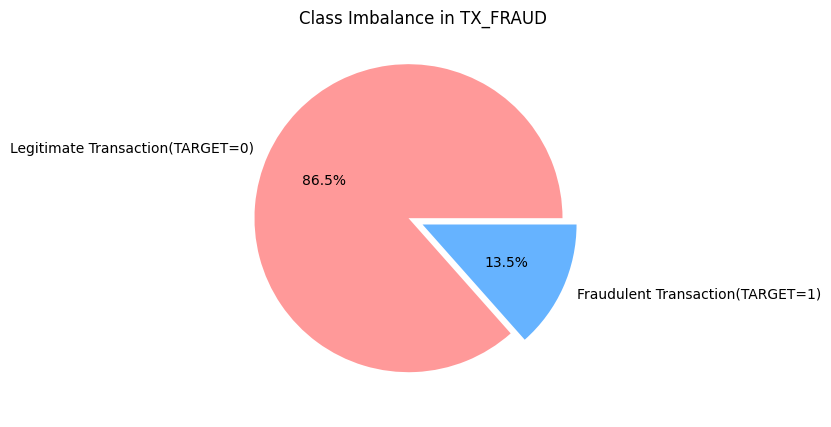

In [ ]:
# Check for class imbalance
fraud_dist = df['TX_FRAUD'].value_counts(normalize=True) * 100

x = ['Legitimate Transaction(TARGET=0)', 'Fraudulent Transaction(TARGET=1)']

explode = (0.1, 0)  # only "explode" the 1st slice

plt.figure(figsize=(5,5))
fraud_dist.plot.pie(explode=explode, labels=x, autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'])
plt.title('Class Imbalance in TX_FRAUD')
plt.ylabel('')
plt.show()

In [ ]:
# Extract time-based features
df['TX_DATETIME'] = pd.to_datetime(df['TX_DATETIME'])

df['hour'] = df['TX_DATETIME'].dt.hour
df['day'] = df['TX_DATETIME'].dt.day
df['month'] = df['TX_DATETIME'].dt.month

In [ ]:
monthly_trends = df.groupby(['month', 'TX_FRAUD']).size().unstack().reset_index()
monthly_trends.columns = ['Month', 'Legitimate', 'Fraudulent']

fig = px.bar(
    monthly_trends,
    x='Month',
    y=['Legitimate', 'Fraudulent'],
    title='Monthly Trends: Fraudulent vs. Legitimate Transactions',
    labels={'value': 'Number of Transactions', 'variable': 'Transaction Type'},
    barmode='stack',
    color_discrete_map={'Legitimate': 'skyblue', 'Fraudulent': 'salmon'}
)

fig.show()

In [ ]:
daily_trends = df.groupby(['day', 'TX_FRAUD']).size().unstack().reset_index()
daily_trends.columns = ['Day', 'Legitimate', 'Fraudulent']

fig = px.bar(
    daily_trends,
    x='Day',
    y=['Legitimate', 'Fraudulent'],
    title='Daily Trends: Fraudulent vs. Legitimate Transactions',
    labels={'value': 'Number of Transactions', 'variable': 'Transaction Type'},
    barmode='stack',
    color_discrete_map={'Legitimate': 'Teal', 'Fraudulent': 'Orange'}
)

fig.show()

In [ ]:
hourly_trends = df.groupby(['hour', 'TX_FRAUD']).size().unstack().reset_index()
hourly_trends.columns = ['Hour', 'Legitimate', 'Fraudulent']

fig = px.bar(
    hourly_trends,
    x='Hour',
    y=['Legitimate', 'Fraudulent'],
    title='Hourly Trends: Fraudulent vs. Legitimate Transactions',
    labels={'value': 'Number of Transactions', 'variable': 'Transaction Type'},
    barmode='stack',
    color_discrete_map={'Legitimate': 'lightgreen', 'Fraudulent': 'darkred'}
)

fig.show()

In [ ]:
df['date'] = df['TX_DATETIME'].dt.date
fraud_trends = df[df['TX_FRAUD'] == 1].groupby('date').size().reset_index(name='Fraudulent Transactions')

fig = px.line(
    fraud_trends,
    x='date',
    y='Fraudulent Transactions',
    title='Fraudulent Transactions Over Time',
    labels={'date': 'Date', 'Fraudulent Transactions': 'Number of Fraud Cases'},
    line_shape='spline',
    color_discrete_sequence=['#E74C3C']
)

fig.show()

In [ ]:
X = df[['TX_AMOUNT', 'TX_TIME_SECONDS', 'TX_TIME_DAYS']]
y = df['TX_FRAUD']

print('Features:\n', X.head())
print('Target Class:\n', y.head())

Features:
    TX_AMOUNT  TX_TIME_SECONDS  TX_TIME_DAYS
0     533.07               31             0
1     808.56              130             0
2    1442.94              476             0
3     620.65              569             0
4     490.66              634             0
Target Class:
 0    0
1    0
2    1
3    0
4    0
Name: TX_FRAUD, dtype: int64


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print(f'Training Data Shape: {X_train.shape}, Test Data Shape: {X_test.shape}')

Training Data Shape: (1403324, 3), Test Data Shape: (350831, 3)


In [22]:
models = {
    "Logistic Regression": LogisticRegression(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=50, max_depth=10),
    "Gradient Boosting": GradientBoostingClassifier()
}

# Use StratifiedKFold for consistent class distribution
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_model = None
best_f1_score = 0

for name, model in models.items():
    print(f'\nTraining {name}...')

    # Pipeline: Standardization → SMOTE → Model
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('smote', SMOTE(random_state=42)),
        ('model', model)
    ])

    # Train the model on training set
    pipeline.fit(X_train, y_train)
    train_f1 = f1_score(y_train, pipeline.predict(X_train))  # Training score

    # Perform Cross-validation
    val_f1_scores = cross_val_score(pipeline, X_train, y_train, cv=skf, scoring='f1', n_jobs=-1)
    avg_val_f1 = np.mean(val_f1_scores)  # Validation score

    print(f'{name} Training F1-score: {train_f1:.6f}')
    print(f'{name} Validation Avg F1-score: {avg_val_f1:.6f}')

    # Best Model
    if avg_val_f1 > best_f1_score:
        best_f1_score = avg_val_f1
        best_model = model

print(f'\nBest Model: {type(best_model).__name__}')


Training Logistic Regression...
Logistic Regression Training F1-score: 0.815752
Logistic Regression Validation Avg F1-score: 0.816451

Training K-Nearest Neighbors...
K-Nearest Neighbors Training F1-score: 0.975867
K-Nearest Neighbors Validation Avg F1-score: 0.963057

Training Decision Tree...
Decision Tree Training F1-score: 1.000000
Decision Tree Validation Avg F1-score: 0.928393

Training Random Forest...
Random Forest Training F1-score: 0.982150
Random Forest Validation Avg F1-score: 0.982142

Training Gradient Boosting...
Gradient Boosting Training F1-score: 0.982147
Gradient Boosting Validation Avg F1-score: 0.982142

Best Model: GradientBoostingClassifier


In [25]:
from sklearn.metrics import recall_score

best_model_params = {
    "LogisticRegression": {'model__C': [0.1, 1, 10], 'model__solver': ['liblinear']},
    "KNeighborsClassifier": {'model__n_neighbors': [3, 5], 'model__weights': ['uniform', 'distance']},
    "DecisionTreeClassifier": {'model__max_depth': [10, 20], 'model__min_samples_split': [2, 5, 10]},
    "RandomForestClassifier": {'model__n_estimators': [50, 100], 'model__max_depth': [10, 20]},
    "GradientBoostingClassifier": {'model__learning_rate': [0.01, 0.1, 0.2], 'model__n_estimators': [50, 100]}
}

best_model_name = best_model.__class__.__name__
params = best_model_params.get(best_model_name, {})

if not params:
    raise ValueError(f"No hyperparameters found for {best_model_name}")

print(f'\nHyperparameter Tuning for {best_model_name}...')

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('model', best_model)
])

# HalvingGridSearchCV for hyperparameter tuning
grid_search = HalvingGridSearchCV(pipeline, params, cv=skf, scoring='recall', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model from HalvingGridSearch
final_model = grid_search.best_estimator_

# Predictions on Test Set
y_pred = final_model.predict(X_test)
final_recall = recall_score(y_test, y_pred)

print(f'\nBest Hyperparameters: {grid_search.best_params_}')
print(f'Best Cross-Val Recall: {grid_search.best_score_:.6f}')
print(f'Final Test Recall: {final_recall:.6f}')


Hyperparameter Tuning for GradientBoostingClassifier...


KeyboardInterrupt: 

In [26]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Legitimate', 'Fraudulent'], yticklabels=['Legitimate', 'Fraudulent'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

NameError: name 'y_pred' is not defined

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
# Save the trained model
joblib.dump(final_model, 'fraud_detection_model.pkl')

In [27]:
!pip install streamlit -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 50.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 75.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.1 MB/s eta 0:00:00


In [28]:
!wget -q -O - ipv4.icanhazip.com

35.227.93.95


In [29]:
! streamlit run app.py & npx localtunnel --port 8501



⠙⠹⠸⠼⠴⠦⠧⠇⠏Need to install the following packages:
localtunnel@2.0.2
Ok to proceed? (y) 
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.227.93.95:8501

y

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸your url is: https://eleven-knives-battle.loca.lt
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:380: InconsistentVersionWarning: Trying to unpickle estimator NearestNeighbors from version 1.4.2 when using version 1.6.1. This might lead to breaking code or invalid results. Use at your own risk. For more info p